In [23]:
import numpy as np
import pandas as pd
import random

import matplotlib.pylab as plt

import astropy
from astropy.modeling import models
from astropy import units as u

import pylab as plb
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

from readmultispec import readmultispec #https://github.com/kgullikson88/General/blob/master/readmultispec.py
import eqwidth

from scipy.stats import norm

from glob import glob
import os
import re

#feb
%matplotlib inline

In [33]:
#Reads in the spectra files
working_dir_path = '/Volumes/external_drive/Astro_Research/OSMOS_data/jan2020/spectra/' #where I want my output to go
globpath = os.path.join(working_dir_path, '/Volumes/external_drive/Astro_Research/OSMOS_data/jan2020/reduce_data/d*.fits') #where the spectra is

filelist = glob(globpath)
filelist.sort()
print (len(filelist)) #how many files

#reading spectra
readFITSfile = readmultispec(filelist[1]) #picking the second file, this arbitrary

# header
readFITSfile['header']

#exposure time
# readFITSfile['header']['EXPTIME'] #the first thing brakets emphasizes the header, and the second thing is what keyword

32
Dispersion is linear


SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    3 / Number of axes                                 
NAXIS1  =                 4136 / Axis length                                    
NAXIS2  =                    1 / Axis length                                    
NAXIS3  =                    4 / Axis length                                    
EXTEND  =                    T / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2019-12-03T18:58:47' / Date FITS file was generated                  
IRAF-TLM= '2019-12-03T18:58:47' / Time of last modification                     
OBJECT  = '2M20381609'         / Name of the object observed                    
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics',

## Taking a Look at the Spectra

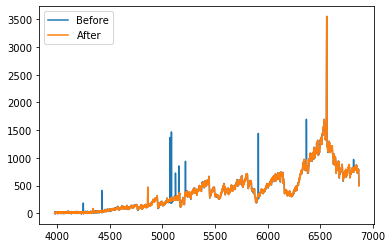

In [25]:
#flux has four dimensions which stands for

# BANDID1 = 'spectrum - optimally extracted'
# BANDID2 = 'spectrum - straight sum'
# BANDID3 = 'sky background'
# BANDID4 = 'sigma   '

#remember 1 is 0 in python
wave = readFITSfile['wavelen'] #wavelength , also note it's not technically found in header
flux = readFITSfile['flux'][0] #flux , bandid1, also note it's not technically found in header
flux_err = readFITSfile['flux'][3] #flux error, bandid4, also note it's not technically found in header

#trying to pick the right flux
plt.plot(wave,readFITSfile['flux'][1],label="Before") 
plt.plot(wave,flux,label="After") #already called flux, so no need to worry about using the right one
plt.legend()

## Fitting the Halpha-Line -- SINGLE OBJECT (TEST)
Try changing the fitting code to use something more common like curve-fit.

1. Make a smaller range of values: reduced wavelength array, flux array and flux error array to region. SO from halpha wavelength-100 angstroms to halpha wavelength+100 angstroms. This is the orange in the top plot.

2. Fit the continuum within this new region a different gaussian that shouldn't fit the halpha line. This the blue in the top plot.

3. Normalize the spectrum by dividing it by the continuum fit (the fit is like a function; gives you y-axis values), because halpha is onto of continuum and we want to flatten it (see second plot)

4. Fit the halpha within this smaller and flatten region with a gaussians. 

5. Use equation to find radial velocity, which will be later used to shift spectra.

error: a,b,c [1.57779561e-04 3.10631505e+00 2.03845760e+04 4.45881330e+07]
a,b,c [ 2.44663300e-04 -4.90040285e+00  3.27031441e+04 -7.27171742e+07]


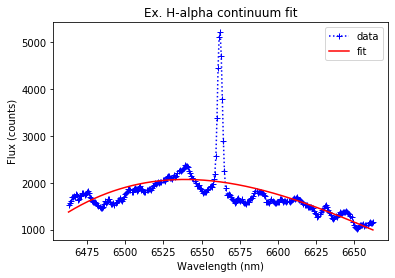

In [34]:
mean0 = 6562.81 #halpha lab wavelength
minx=mean0-100. #defines minimum value of new region 
maxx=mean0+100. #defines maximum value of new region 

#defining the subregions. e.g. fluxcut: use the flux where the a condition is true to where the b condition is true --> flux[a:b]
sub_wave_c = np.linspace(minx,maxx,len(wave)) #h-alpha subregion, x-axis
fluxcut = flux[np.argmin(np.abs((wave)-np.min(sub_wave_c))):np.argmin(np.abs((wave)-np.max(sub_wave_c)))] #flux cut
fluxcut_err = flux_err[np.argmin(np.abs((wave)-np.min(sub_wave_c))):np.argmin(np.abs((wave)-np.max(sub_wave_c)))] #wave cut
wavecut = wave[np.argmin(np.abs((wave)-np.min(sub_wave_c))):np.argmin(np.abs((wave)-np.max(sub_wave_c)))] #wave cut

# Fit the continuum:
x = wavecut
y = fluxcut

## Fitting Polynomial to Continuum:
# weighted arithmetic mean (corrected - check the section below)
mean = wavecut[np.argmax(fluxcut)]
sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))

def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def Polynomial(x,a,b,c,d):  #third order polynomial
    # return a*x**2 + b*x + c
    return a*x**3 + b*x**2 + c*x + d

popt,pcov = curve_fit(Polynomial, x, y)
err = np.sqrt(np.diag(pcov))
print("error: a,b,c", err) # the third one is the one we will be using
print("a,b,c", popt)

plt.plot(x, y, 'b+:', label='data')
plt.plot(x, Polynomial(x, *popt), 'r-', label='fit')

plt.legend()
plt.title('Ex. H-alpha continuum fit')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Flux (counts)')
plt.show()



## Fitting H-alpha

error: offset, peak, mean, sigma [0.01023476 0.02680958 0.02637629 0.0293215 ]
offset, peak, mean, sigma [ 8.85416541e-01  1.72581808e+00  6.56197792e+03 -1.52714335e+00]


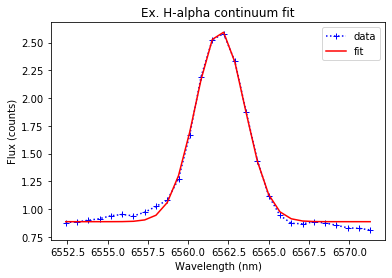

In [35]:
# We normalize the flux by dividing it by the continuum fit
norm_flux = (y/Polynomial(x, *popt))
# amp = np.max(norm_flux) # initial guess for the peak of the normalize flux

#cut the data to focus on h-alpha subregion, subregion to id halpha, fit better
mean0 = wavecut[np.argmax(fluxcut)] #halpha lab wavelength
minx2=mean0-10 #defines minimum value of new region 
maxx2=mean0+10 #defines maximum value of new region 

#defining the subregions. e.g. fluxcut: use the flux where the a condition is true to where the b condition is true --> flux[a:b]
sub_wave_c2 = np.linspace(minx2,maxx2,len(wavecut)) #h-alpha subregion, x-axis
fluxcut2 = norm_flux[np.argmin(np.abs((wavecut)-np.min(sub_wave_c2))):np.argmin(np.abs((wavecut)-np.max(sub_wave_c2)))] #flux cut
fluxcut_err2 = flux_err[np.argmin(np.abs((wavecut)-np.min(sub_wave_c2))):np.argmin(np.abs((wavecut)-np.max(sub_wave_c2)))] #wave cut
wavecut2 = wavecut[np.argmin(np.abs((wavecut)-np.min(sub_wave_c2))):np.argmin(np.abs((wavecut)-np.max(sub_wave_c2)))] #wave cut

x2 = wavecut2
y2 = fluxcut2

# weighted arithmetic mean (corrected - check the section below)
mean2 = mean0
sigma2 = np.sqrt(sum(y2 * (x2 - mean2)**2) / sum(y2))

def gaussian_offset(x, *pars):
     offset = pars[0]
     g1 = Gauss(x, pars[1], pars[2], pars[3])
     return g1 + offset

popt2,pcov2 = curve_fit(gaussian_offset, x2, y2, p0=[1, max(y2), mean2, sigma2])
err2 = np.sqrt(np.diag(pcov2))
print("error: offset, peak, mean, sigma", err2) # the third one is the one we will be using
print("offset, peak, mean, sigma", popt2)

plt.plot(x2, y2, 'b+:', label='data')
#plt.plot([mean2, mean2], [1, 2.3])
plt.plot(x2, gaussian_offset(x2, *popt2), 'r-', label='fit')
plt.legend()
plt.title('Ex. H-alpha continuum fit')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Flux (counts)')
plt.show()


## Fitting the Halpha-Line -- LOOP (+ Shifting)

So what following is doing is the same as cell above but for more than one object.

1. Make a smaller range of values: reduced wavelength array, flux array and flux error array to region. SO from halpha wavelength-100 angstroms to halpha wavelength+100 angstroms. This is the orange in the top plot.

2. Fit the continuum within this new region a different gaussian that shouldn't fit the halpha line. This the blue in the top plot.

3. Normalize the spectrum by dividing it by the continuum fit (the fit is like a function; gives you y-axis values), because halpha is onto of continuum and we want to flatten it (see second plot)

4. Fit the halpha within this smaller and flatten region with a gaussians. 

5. Use equation to find radial velocity, which will be later used to shift spectra.

Additions: 6. Using the radial velocity measurement to shift the spectra.

In [36]:
def return_newFlux(flux, flux_err): #adding noise to flux values
    center = flux
    width = flux_err
    newFlux = np.random.normal(center,width) #gaussian to 
    return newFlux
    
def mea_vel(w2,w1):
    '''
    This equation gives us Radial Velocities
    '''
    c = 299792 #km/s
    return (c*(w2-w1)/w1) #w2 = observed halpha and w1 = measure halpha

def newwave(wave,vel): 
    '''
    This equation is giving us the new values of wavelength, i.e. this shifting the spectra
    '''
    c = 299792 #km/s
    return wave*(1-(vel/c))

def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def Polynomial(x,a,b,c,d): #third order polynomial
    return a*x**3 + b*x**2 + c*x + d


## Fitting the Halpha-Line -- LOOP (CURVE_FIT)

In [38]:
name = np.loadtxt("/Volumes/external_drive/Astro_Research/OSMOS_data/jan2020/reduce_data/SpecKey200103_200108",dtype=str, usecols=8)

N= len(name) #number of spectra

steps=1000

def Halpha_EQ(file):
    readFITSfile = readmultispec(file) #Reading the FITS
    wave = readFITSfile['wavelen'] #taking the wavelength observed from FITS
    flux_ori = readFITSfile['flux'][0] #taking the flux observed from FITS
    flux_err = readFITSfile['flux'][3] #taking the flux error observed from FITS
    
    EWs = []
    for j in range (steps):
        flux = return_newFlux(flux_ori,flux_err) #new flux

        ## Fitting the continuum:
        mean0 = 6562.81 #halpha lab wavelength
        minx=mean0-100 #defines minimum value of new region 
        maxx=mean0+100 #defines maximum value of new region 

        #defining the subregions. e.g. fluxcut: use the flux where the a condition is true to where the b condition is true --> flux[a:b]
        sub_wave_c = np.linspace(minx,maxx,len(wave)) #h-alpha subregion, x-axis
        fluxcut = flux[np.argmin(np.abs((wave)-np.min(sub_wave_c))):np.argmin(np.abs((wave)-np.max(sub_wave_c)))] #flux cut
        fluxcut_err = flux_err[np.argmin(np.abs((wave)-np.min(sub_wave_c))):np.argmin(np.abs((wave)-np.max(sub_wave_c)))] #wave cut
        wavecut = wave[np.argmin(np.abs((wave)-np.min(sub_wave_c))):np.argmin(np.abs((wave)-np.max(sub_wave_c)))] #wave cut

        # Fit the continuum:
        x = wavecut
        y = fluxcut

        ## TRY 1 w/ one gaussian:
        # weighted arithmetic mean (corrected - check the section below)
        mean = wavecut[np.argmax(fluxcut)]
        sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))

        popt,pcov = curve_fit(Polynomial, x, y)
        err = np.sqrt(np.diag(pcov))

        fig, (ax0,ax1) = plt.subplots(2,figsize=(15,10))
        ax0.plot(x, y, 'b+:', label='data')
        ax0.plot(x, Polynomial(x, *popt), 'r-', label='fit')
        ax0.legend()
        ax0.set_xlabel('Wavelength (nm)')
        ax0.set_ylabel('Flux (counts)')

        ## Fitting H-alpha:
        # We normalize the flux by dividing it by the continuum fit
        norm_flux = (y/Polynomial(x, *popt))
        # amp = np.max(norm_flux) # initial guess for the peak of the normalize flux

        #cut the data to focus on h-alpha subregion, subregion to id halpha, fit better
        mean0 = wavecut[np.argmax(fluxcut)] #halpha lab wavelength
        minx2=mean0-3 #defines minimum value of new region 
        maxx2=mean0+3 #defines maximum value of new region 

        #defining the subregions. e.g. fluxcut: use the flux where the a condition is true to where the b condition is true --> flux[a:b]
        sub_wave_c2 = np.linspace(minx2,maxx2,len(wavecut)) #h-alpha subregion, x-axis
        fluxcut2 = norm_flux[np.argmin(np.abs((wavecut)-np.min(sub_wave_c2))):np.argmin(np.abs((wavecut)-np.max(sub_wave_c2)))] #flux cut
        fluxcut_err2 = flux_err[np.argmin(np.abs((wavecut)-np.min(sub_wave_c2))):np.argmin(np.abs((wavecut)-np.max(sub_wave_c2)))] #wave cut
        wavecut2 = wavecut[np.argmin(np.abs((wavecut)-np.min(sub_wave_c2))):np.argmin(np.abs((wavecut)-np.max(sub_wave_c2)))] #wave cut

        x2 = wavecut2
        y2 = fluxcut2

        # weighted arithmetic mean (corrected - check the section below)
        mean2 = mean0
        sigma2 = np.sqrt(sum(y2 * (x2 - mean2)**2) / sum(y2))

        popt2,pcov2 = curve_fit(Gauss, x2, y2, p0=[max(y2), mean2, sigma2])

        err2 = np.sqrt(np.diag(pcov2))

        ax1.plot(x2, y2, 'b+:', label='data')
        ax1.plot(x2, Gauss(x2, *popt2), 'r-', label='fit')

        ax1.legend()
        ax1.set_xlabel('Wavelength (nm)')
        ax1.set_ylabel('Flux (counts)')
        plt.close()

        nwave=newwave(wave,np.asarray(mea_vel(popt2[1],mean0)))
        EWs.append(eqwidth.measure_ha(nwave,flux)) #note: flux is newflux (i.e. plus noise)
    
    low,high,med=np.percentile(EWs, q=[16,84,50]) #finds the 1-sigma errors and actualy equivalent widths values

    return EWs, med-low, high-med, med


Dispersion is linear
Dispersion is linear
Dispersion is linear
Dispersion is linear
Dispersion is linear
Dispersion is linear
Dispersion is linear
Dispersion is linear
Dispersion is linear
Dispersion is linear
Dispersion is linear
Dispersion is linear
Dispersion is linear
Dispersion is linear
Dispersion is linear
Dispersion is linear
Dispersion is linear
Dispersion is linear
Dispersion is linear
Dispersion is linear
Dispersion is linear
Dispersion is linear
Dispersion is linear
Dispersion is linear
Dispersion is linear
Dispersion is linear
Dispersion is linear
Dispersion is linear
Dispersion is linear
Dispersion is linear
Dispersion is linear
Dispersion is linear



## Finding Halpha Equivalent Width (Code from Thomas + Elisabeth) Part 1

1. We are fitting each data point with a gaussian. The peak is the data point and the wings correspond to the error bars.

2. We are then adding these flux offsets to the flux data in order to caclulate where the centroid should actually be (this will be done to the wavelength information) 

3. Given that we do not currently account for spectrum shift, this process will eventually be expanded.

## Saving the Results in a Table

In [45]:
for i in range(N):
    EQ=Halpha_EQ(filelist[i])
    folder = "/Users/aylingarcias/Year1/Scripts/TIC_folders/" #change it to where you want it
    d = {'EW': EQ[3], 'EW_lerr': EQ[1],'EW_uerr': EQ[2]}
    df = pd.DataFrame(data=d,index=[1]).to_csv(folder+'/{}'.format(str(filelist[i]).split('/')[6].split('.')[0])+"EQs_output.csv",index=None)
